In [19]:
from os import path
import json
from data_collection import load_or_download_books
from data_preprocessing import preprocess_all_books
from data_analysis import return_most_common, unique_words_from_texts, calculate_tf_idf
from data_graphing import create_wordcloud, create_barchart, create_mean_word_length_chart, generate_color_map, create_color_func, plot_tfidf_heatmap

# Introduction and Data Collection

In this project I will analyze the word usage in five Sherlock Holmes novels. I've separated my scripts into different files (data_collection, data_preprocessing, data_analysis, and data_graphing) to improve organization. In this notebook I'll run the functions which I have in main.py and show what those functions are in the markdown text. In the code segments, I will run the defined functions as necessary (to process the text, graph it, etc.). To begin, I specify five Project Gutenberg urls which link to Sherlock Holmes novels. Project Gutenberg is a copyright-free respository of full novel texts. 

```python
urls = [
    "https://www.gutenberg.org/cache/epub/244/pg244.txt",    # A Study in Scarlet
    "https://www.gutenberg.org/cache/epub/3289/pg3289.txt",  # The Valley of Fear
    "https://www.gutenberg.org/cache/epub/2097/pg2097.txt",  # The Sign of the Four
    "https://www.gutenberg.org/cache/epub/2852/pg2852.txt",  # The Hound of the Baskervilles
    "https://www.gutenberg.org/cache/epub/1661/pg1661.txt",  # The Adventures of Sherlock Holmes
    ]
```

I use URL requests to download the text from the specified URLs, then use regex to extract metadata (Title, Author, Language; I don't use author or language, but include them for demonstrative purposes).

```python
# URL request; return plain text if successful 
def download_book(url):
    """
    Download the text from a given URL.
    Args: 
        url (string): Contains a Project Gutenberg URL.
    """
    response = requests.get(url)
    if response.status_code == 200:  # HTTP status code for OK
        return response.text
    else:
        print(f"Failed to download book from {url}")
        return None

# Get title, author, and language from the downloaded text
def extract_metadata(raw_text):
    """
    Extract metadata from the raw text.
    Args: 
        raw_text (string): Contains the unprocessed, downloaded text 
    """
    title_match = re.search(r"Title:\s*(.*?)\s*\n", raw_text)
    author_match = re.search(r"Author:\s*(.*?)\s*\n", raw_text)
    language_match = re.search(r"Language:\s*(.*?)\s*\n", raw_text)
    title = title_match.group(1) if title_match else "Unknown Title"
    author = author_match.group(1) if author_match else "Unknown Author"
    language = language_match.group(1) if language_match else "Unknown Language"
    return {"title": title, "author": author, "language": language}
```
With these functions, I save the full text (and metadata) to a JSON file (if the JSON file doesn't exist). If it does exist, I return the raw text JSON to be used later.  

```python
# Load raw books if available; if not, redownload them
def load_or_download_books():
    """
    If the book has not already been downloaded, download it, extract metadata, and save to a JSON file. If the book has been 
    downloaded, load the JSON file and open it.
    """
    try: 
        with open("books_raw.json", "r", encoding="utf-8") as f:
            rawbooks = json.load(f) 
            if not rawbooks:  # Check if the file is empty
                raise ValueError("The JSON file is empty.")
    except (FileNotFoundError, ValueError):
        # Download books to a JSON file if they haven't been downloaded
        print("Unable to load books_raw.json. Downloading books...")
        books = []
        for url in urls:
            raw_text = download_book(url)
            if raw_text:
                metadata = extract_metadata(raw_text)
                metadata["text"] = raw_text  # Include the full raw text
                books.append(metadata)
         # Save all books to the JSON file
        with open("books_raw.json", "w", encoding="utf-8") as f:
            json.dump(books, f, indent=4)
        # Reopen the file to read the saved data
        with open("books_raw.json", "r", encoding="utf-8") as f:
            rawbooks = json.load(f)            
    return rawbooks
```

In [20]:
# Load raw books, if available; if not, download them and save to books_raw.json
books = load_or_download_books()

# Data Preprocessing

Using regex and the NLTK package, I preprocess the text before I begin my analysis. I make it lowercase, remove the preamble and closing statements (from Project Gutenberg), remove digits, remove chapter numerals and some common words that NLTK doesn't account for, replace puncutation and dashes with spaces, remove multiple spaces, and remove trailing and leading spaces. Each of these actions is doable with a single line of code, so I kept all of this within one function. Finally, using NLTK, I tokenize the text and lemmatize it (which truncates words down to their base; for example, fires becomes fire). If a word is not contained in the NLTK stopword list, I add the word to my final list of filtered text. 

```python
def preprocess_text(text):
    """Convert raw text to preprocessed text.
        Args: 
            text (string): Contains the unprocessed, downloaded text 
    """
    # Make all text lower-case
    text = text.lower()
    # Remove the introductory Project Gutenberg text (before the book starts)
    text = re.sub(r"^.*?( \*\*\*)", "", text, flags=re.DOTALL)
    # Remove the end Project Gutenberg text (after the book ends)
    text = re.sub(r"(end of the project gutenberg.*)", "", text, flags=re.DOTALL)
    # Remove digits
    text = re.sub(r"\d+", "", text)
    # Remove Roman numerals (chapter numbers) and other words not handled correctly by NLTK
    text = re.sub(r"\b(ii|iii|iv|v|vi|vii|viii|ix|x|xi|xii|was|has|yes|said|us|would|could|upon|one|two|well|may)\b", "", text)
    # Replace punctuation with space 
    text = re.sub(r"[^\w\s]", " ", text) 
    # Replace dashes (hyphen, en dash, em dash) with spaces to preserve word separation
    text = re.sub(r"[\u2014\u2013\-_()]", " ", text)
    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)
    # Strip leading and trailing spaces
    text = text.strip()
    # Tokenize the text
    text = word_tokenize(text)
    # Lemmatize the text (rocks -> rock)
    lemmatized_text = []
    for w in text:
        lemmatized_text.append(WordNetLemmatizer().lemmatize(w))
    # Recreate the tokenized list but without NLTK stopwords
    filtered_text = []
    for w in lemmatized_text:
        if w not in stopwords.words('english'):
            filtered_text.append(w)
    return filtered_text
```
I load the book saved in the JSON file and use it in the function below to replace its raw text with a list of processed words.

```python
def preprocess_all_books(books_raw):
    """Convert raw text to preprocessed text.
        Args: 
            books_raw (json object): Contains all of the raw books - their text and metadata 
    """
    for book in books_raw:
        cleaned_text = preprocess_text(book["text"])  # Clean the raw text
        book["text"] = cleaned_text  # Replace the raw text with the cleaned version
```
Finally, I save this new processed text back to books_cleaned.json then open it and save it to a cleaned_books object to use in my analysis. It's easier to make a wordcloud with the wordcloud package using the processed text in a string format, so I'll make a dict with the title and text of each book and save to books_text and all_text (which contain a dict with the texts of the five books separated and a dict with the text of all books together, respectively).

In [21]:
# Preprocess each book (remove text, make lowercase, etc.) and update its text field
preprocess_all_books(books)

# Save the processed text back to a new JSON file
with open("books_cleaned.json", "w", encoding="utf-8") as file:
    json.dump(books, file, indent=4, ensure_ascii=False)  
    
# Read the processed text
with open("books_cleaned.json", "r", encoding="utf-8") as f:
    cleaned_books = json.load(f)

# Text from each book in string format to generate WordCloud
books_text = {book['title']: ' '.join(book['text']) for book in cleaned_books}

# Text from all novels in string format to generate WordCloud
all_text = {
    "Sherlock Holmes Novels": ' '.join(books_text.values()),
}


# WordCloud of 10 Most Common Words in Each Novel

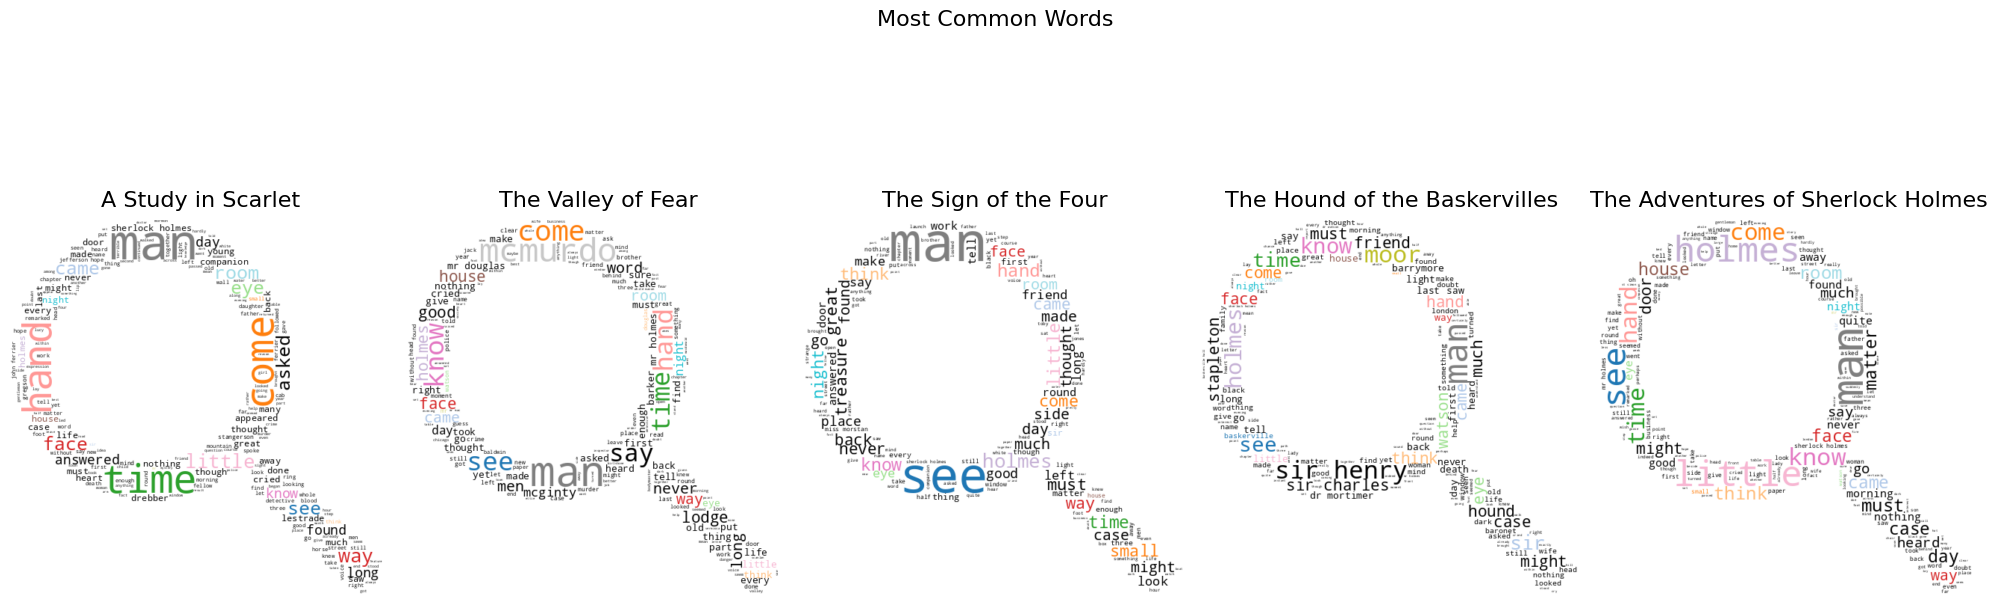

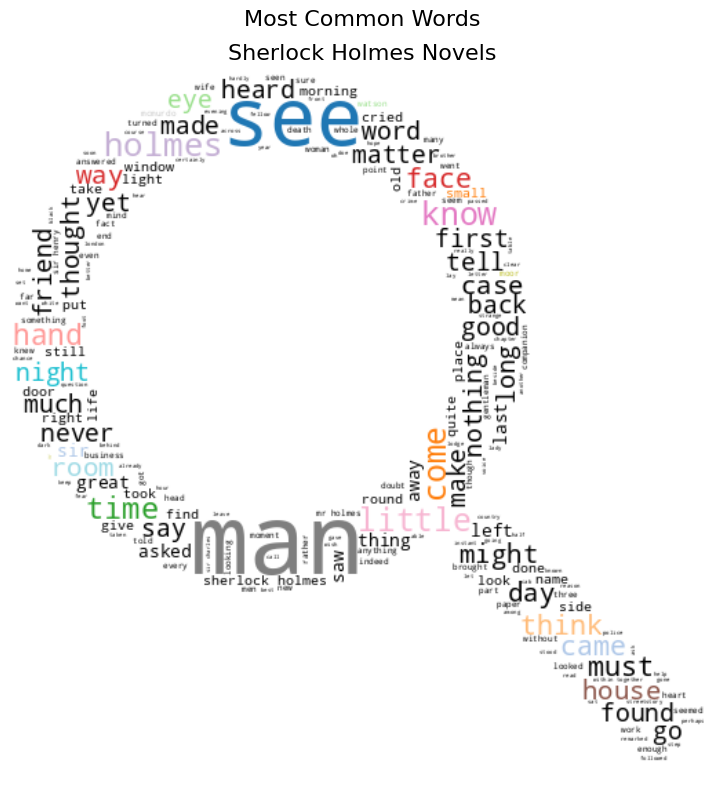

In [23]:
# 10 most common words for each book
books_common_words = {title: return_most_common(text, 10) for title, text in books_text.items()}

# 10 most common words for all of the novels
all_text_common_words  = {
    "Sherlock Holmes Novels": return_most_common(all_text["Sherlock Holmes Novels"], 10),
}

# Take the most common words and assign a color to them which is consistent for graphical analysis. Wordclouds use a color function, barcharts use a color mapping
common_words = set(word for book in books_common_words.values() for word, _ in book)
color_map = generate_color_map(common_words)
color_func = create_color_func(color_map)

# Create 5 wordclouds for each of the novels showing most common words
create_wordcloud(books_text, color_func)

# Create a wordcloud which shows the most common words for all novels
create_wordcloud(all_text, color_func)
